In [53]:
from tpot import TPOTRegressor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection   import GridSearchCV
import plotly.express as px

## DATA

In [54]:
%%time
# data
acidoCEST_ML = pd.read_csv('acido_CEST_MRI_MegaBox_01_to_08_clean.csv')
acidoCEST_ML = acidoCEST_ML.drop(['Unnamed: 0','ApproT1(sec)','FILE'], axis = 1)
c = acidoCEST_ML.iloc[:,10::].columns.tolist()

Z = acidoCEST_ML.iloc[:,10::].copy()

freqs = np.array( [float(x) for x in Z.columns ] )
freqs = freqs - freqs[np.argmin(Z.median().values )]
Z.columns = [str( np.round(x,2)) for x in freqs ]

f1 = acidoCEST_ML['SatTime(ms)'] > 2000
f2 = acidoCEST_ML['SatPower(uT)'] > 1.
f3 = acidoCEST_ML['Conc(mM)'] > 10
f4 = acidoCEST_ML.Temp = 37

CPU times: user 800 ms, sys: 98.7 ms, total: 899 ms
Wall time: 899 ms


## LASSO (Linear Model)

$$ \min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1} $$

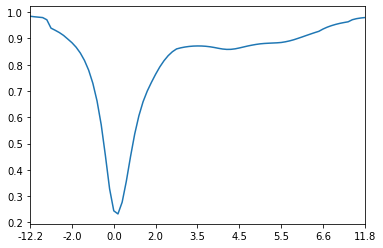

In [55]:
X.mean().plot()

In [56]:
X = Z.copy()
y = acidoCEST_ML.pH

In [57]:
alphas = np.linspace(1E-6,.005,1000)

selected_freqs = []

l = ['alpha']
l.extend(Z.columns)

I = pd.DataFrame( np.zeros( (len(alphas), len(l) ) ), columns= l )


for i,A in enumerate(alphas):
    L = Lasso(alpha = A, fit_intercept=True , normalize=False,max_iter=1000000,tol=.01).fit(X,y)
    model = SelectFromModel(L, prefit=True)
    X_new = model.transform(X)
    selected_freqs.append( X_new.shape[1] )
    
    I.loc[i,'alpha'] = A
    
    I.loc[i, Z.columns] = L.coef_
    


In [58]:
w= (I.loc[:, Z.columns] !=0)*1
w = 100 * w.sum()/ 1000
w = pd.DataFrame(w.reset_index())
w.columns = ['Saturation Frequency','Selection']

fig = px.scatter(w, x="Saturation Frequency", y='Selection', title='Time (%) a frequency is non zero for 1000 alphas')
fig.show()

In [59]:
w = np.abs(I.loc[:, Z.columns]).mean()
w = pd.DataFrame(w.reset_index())
w.columns = ['Saturation Frequency','Mean Coefficient']
fig = px.scatter(w, x="Saturation Frequency", y='Mean Coefficient'
              , title='Mean Importance for 1000 alphas')
fig.show()

In [60]:
w = w.sort_values('Mean Coefficient',ascending=False)
w['LASSO_rank'] = np.arange(1,82)


### Performance

In [61]:
parameters = {'alpha': alphas}

X = Z[f1 & f2 & f3 & f4]
y = acidoCEST_ML.pH[f1 & f2 & f3 & f4]

L = Lasso(fit_intercept=True , normalize=False,max_iter=1000000,tol=.01, positive=False)
clf = GridSearchCV(L, parameters ,verbose=1, n_jobs=-1, cv=3, scoring='r2')
clf.fit(X,y )

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   36.4s
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.01, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 6.00400400e-06, 1.10080080e-05, 1.60120120e-05,
       2.10160160e-05, 2...
       4.90492392e-03, 4.90992793e-03, 4.91493193e-03, 4.91993594e-03,
       4.92493994e-03, 4.92994394e-03, 4.93494795e-03, 4.93995195e-03,
       4.94495596e-03, 4.94995996e-03, 4.95496396e-03, 4.95996797e-03,
       4.96497197e-03, 4.96997598e-03, 4.97497998e-03, 4.97998398e-03,
       4.98498799e-03, 4.98999199e-03, 4.99499600e-03, 5.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=1)

In [62]:
clf.best_estimator_

Lasso(alpha=3.102402402402402e-05, copy_X=True, fit_intercept=True,
      max_iter=1000000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.01, warm_start=False)

Text(0, 0.5, 'R2')

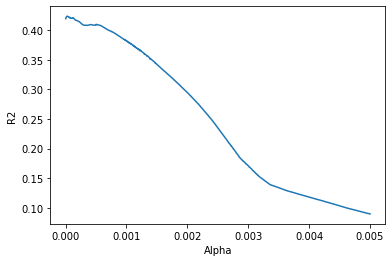

In [63]:
plt.plot(alphas, clf.cv_results_['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2')

## Random Forest Regressor

In [64]:
%%time

parameters = {'n_estimators': [1,2,10,50,100]}

RfR = RandomForestRegressor()
clf2 = GridSearchCV(RfR, parameters ,verbose=1, n_jobs=-1, cv=3, scoring='r2')
clf2.fit(X,y )

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.5s finished


CPU times: user 27.1 s, sys: 123 ms, total: 27.2 s
Wall time: 46.7 s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [65]:
clf2.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
clf2.cv_results_['mean_test_score']

array([0.23532004, 0.43735995, 0.63631914, 0.67320138, 0.67454377])

In [67]:
best = clf2.best_estimator_
FI = pd.DataFrame(best.feature_importances_,index=X.columns)
FI = FI.reset_index()
FI.columns =['Saturation Frequency', 'Importance']
fig = px.scatter(FI, x="Saturation Frequency", y='Importance', title='Time (%) a frequency is non zero for 1000 alphas')
fig.show()

In [68]:
FI = FI.sort_values('Importance',ascending=False)
FI['RF_rank'] = np.arange(1,82)

In [69]:
C = FI.merge(w, left_on='Saturation Frequency',right_on='Saturation Frequency')

In [70]:
C

,Saturation Frequency,Importance,RF_rank,Mean Coefficient,LASSO_rank
0,5.7,0.104360,1,0.313037,3
1,4.5,0.086464,2,0.179380,6
2,4.3,0.066251,3,0.281628,4
3,4.4,0.066204,4,0.147486,8
4,5.8,0.053044,5,0.147282,9
...,...,...,...,...,...
76,7.2,0.002230,77,0.004821,36
77,11.8,0.002151,78,0.000897,53
78,-6.2,0.002143,79,0.001392,50
79,-11.2,0.002105,80,0.000506,62


In [52]:
C.sort_values('RF_rank',ascending=False).head(10)

,Saturation Frequency,Importance,RF,RF_rank,Mean Coefficient,LASSO,LASSO_rank
80,11.8,0.001997,81,81,0.000897,53,53
79,-6.2,0.002118,80,80,0.001392,50,50
78,-10.2,0.002173,79,79,0.001014,51,51
77,-12.2,0.002184,78,78,0.000424,63,63
76,-11.2,0.002237,77,77,0.000506,62,62
75,7.2,0.002275,76,76,0.004821,36,36
74,9.8,0.002456,75,75,0.000630,59,59
73,7.6,0.002461,74,74,0.000154,70,70
72,7.4,0.002487,73,73,0.000307,66,66
71,8.8,0.002530,72,72,0.000111,74,74


In [36]:
C.sort_values('Selection',ascending=False).head(10)

,Saturation Frequency,Importance,RF_rank,Selection
6,4.2,0.034102,7,97.2
19,0.4,0.010456,20,95.7
3,4.3,0.070300,4,81.1
12,1.8,0.016179,13,45.5
2,4.4,0.071026,3,37.5
14,4.1,0.013842,15,32.8
0,5.7,0.100397,1,27.7
1,4.5,0.094870,2,27.3
5,5.6,0.047077,6,26.7
53,-1.2,0.003423,54,23.3


In [ ]:
selected_freqs = C[(C.RF_rank <=20) & (C.LASSO_rank <=20)]['Saturation Frequency']
col_list_sel_freqs = [str(f) for f in selected_freqs ]
col_list_sel_freqs.sort()
col_list_sel_freqs

## autoML with selected frequencies

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [ ]:
data = h2o.H2OFrame(pd.concat( (acidoCEST_ML.pH, Z),axis=1))

In [ ]:
train, test, val = data.split_frame( ratios = [.7, .25] )

In [ ]:
x = data.columns
y = "pH"
x.remove(y)


# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1, verbosity='info',nfolds=3,max_runtime_secs=3600)
aml.train(x=x, y=y, training_frame=train)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

## autoML with all 

In [ ]:
col_list_sel_freqs

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml2 = H2OAutoML(max_models=20, seed=1, verbosity='info',nfolds=3,max_runtime_secs=3600)
aml2.train(x = col_list_sel_freqs, y=y, training_frame=train)


In [ ]:
# View the AutoML Leaderboard
lb = aml2.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [75]:
pd.cut(acidoCEST_ML.pH,20).value_counts()

(6.219, 6.276]    4320
(6.386, 6.442]    4140
(6.83, 6.886]     3600
(7.108, 7.164]    3600
(7.274, 7.33]     3420
(6.664, 6.72]     3240
(6.553, 6.608]    2520
(6.997, 7.052]    2340
(6.942, 6.997]    2160
(6.498, 6.553]    1980
(6.72, 6.775]     1260
(7.219, 7.274]    1080
(6.775, 6.83]      900
(7.164, 7.219]     900
(6.331, 6.386]     360
(6.276, 6.331]     180
(6.886, 6.942]       0
(7.052, 7.108]       0
(6.608, 6.664]       0
(6.442, 6.498]       0
Name: pH, dtype: int64

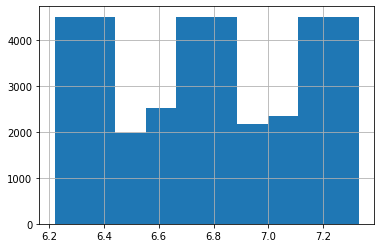

In [72]:
.hist()